In [1]:
cd ../

/home/ubuntu/github/predictive-maintenance/ml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random

from sklearn.preprocessing import normalize

from tqdm import tqdm

%matplotlib inline

tqdm.monitor_interval = 0

In [3]:
data_dir = 'data/dataset/'
model_save_path = 'data/wtte/model/saved_model.h5'

In [4]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Vis.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
telemetry.machineID.nunique()

100

In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
print(telemetry.machineID.nunique())
print(failures.machineID.nunique())

100
98


## Prepare Data

In [10]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [11]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [13]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [14]:
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [15]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

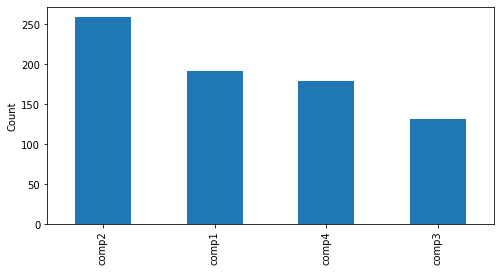

In [16]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## Normliaze

In [17]:
telemetry["volt"] = (telemetry["volt"] - telemetry["volt"].mean()) / telemetry["volt"].std()
telemetry["rotate"] = (telemetry["rotate"] - telemetry["rotate"].mean()) / telemetry["rotate"].std()
telemetry["pressure"] = (telemetry["pressure"] - telemetry["pressure"].mean()) / telemetry["pressure"].std()
telemetry["vibration"] = (telemetry["vibration"] - telemetry["vibration"].mean()) / telemetry["vibration"].std()

In [18]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,0.350769,-0.533491,1.105948,0.875673
1,2015-01-01 07:00:00,1,-0.509282,-0.832626,-0.488578,0.564015
2,2015-01-01 08:00:00,1,0.013680,1.532917,-2.318898,-1.155632
3,2015-01-01 09:00:00,1,-0.536130,-1.907127,0.759357,0.137260
4,2015-01-01 10:00:00,1,-0.849031,-0.213165,0.998127,-2.680359


In [19]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,8.761000e+05,8.761000e+05,8.761000e+05,8.761000e+05
mean,50.500000,1.789195e-15,-3.522008e-15,-3.830069e-15,3.917701e-15
std,28.866087,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-4.735547e+00,-5.850585e+00,-4.491176e+00,-4.749765e+00
25%,25.750000,-6.752680e-01,-6.511653e-01,-6.661870e-01,-6.717814e-01
50%,50.500000,-1.098699e-02,1.809304e-02,-3.920010e-02,-2.751396e-02
75%,75.250000,6.594030e-01,6.753153e-01,6.060963e-01,6.330919e-01
max,100.000000,5.438543e+00,4.716110e+00,7.701674e+00,6.779073e+00


## Change the Life-cycle

In [20]:
# calculate the mean, std, max, and min values for 24h periods
def timesteps_handler(df, period='24H', fields = ['volt', 'rotate', 'pressure', 'vibration']):
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').mean().unstack())
    df_mean_xh = pd.concat(temp, axis=1)
    df_mean_xh.columns = [i + '_mean_{}'.format(period.lower()) for i in fields]
    df_mean_xh.reset_index(inplace=True)

    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').std().unstack())
    df_sd_xh = pd.concat(temp, axis=1)
    df_sd_xh.columns = [i + '_sd_{}'.format(period.lower()) for i in fields]
    df_sd_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').max().unstack())
    df_max_xh = pd.concat(temp, axis=1)
    df_max_xh.columns = [i + '_max_{}'.format(period.lower()) for i in fields]
    df_max_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').min().unstack())
    df_min_xh = pd.concat(temp, axis=1)
    df_min_xh.columns = [i + '_min_{}'.format(period.lower()) for i in fields]
    df_min_xh.reset_index(inplace=True)
    
    df = pd.concat([
        df_mean_xh,
        df_sd_xh.iloc[:, 2:6],
        df_max_xh.iloc[:, 2:6],
        df_min_xh.iloc[:, 2:6]], axis=1).dropna()
    return df

In [21]:
# 24h periods
telemetry = timesteps_handler(telemetry)
telemetry.head(10)

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,0.771248,1.532917,1.105948,1.980589,-1.253589,-1.907127,-2.318898,-2.680359
1,1,2015-01-03,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,1.940452,1.382994,2.367326,2.229063,-1.934438,-1.176278,-1.989187,-2.021716
2,1,2015-01-04,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,1.558123,2.323109,1.371181,4.912055,-1.068951,-1.375975,-1.413025,-1.501089
3,1,2015-01-05,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,2.893702,1.343045,1.628682,4.111287,-2.692677,-1.545193,-1.670593,0.240185
4,1,2015-01-06,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,2.046716,2.447134,2.317554,3.573735,-2.812160,-1.326758,-2.003561,-1.346091
5,1,2015-01-07,0.015945,0.152053,0.137482,0.208910,1.136349,0.828651,0.773030,0.800365,2.773167,1.169388,1.646753,1.386147,-3.177165,-1.921001,-1.233135,-1.409782
6,1,2015-01-08,0.216755,-0.043045,-0.378672,0.245377,0.684218,0.748966,0.965712,1.081624,1.378338,1.865302,1.750360,2.706436,-1.233874,-1.614519,-1.877034,-2.095037
7,1,2015-01-09,0.087574,-0.009081,0.112083,-0.205391,0.891725,0.729886,0.865101,0.769713,1.931981,1.556594,1.272402,0.958858,-1.755520,-1.526450,-1.746216,-2.114125
8,1,2015-01-10,-0.092055,0.384991,-0.066108,-0.337691,0.941405,0.772227,0.766029,0.862540,1.700248,2.007974,1.475786,1.404760,-1.758397,-0.854402,-1.647746,-1.660726
9,1,2015-01-11,0.014734,0.172579,-0.106659,-0.110908,0.803475,0.626868,0.830753,1.010693,1.448955,1.423931,1.709820,1.728380,-1.579632,-0.870167,-1.838805,-1.910094


## Train, Validation, Test Split

In [22]:
import lightgbm as lgb

# make test and training splits
threshold_dates = [
        pd.to_datetime("2015-08-01 01:00:00"),
        pd.to_datetime("2015-11-01 01:00:00")
]

telemetry_train = telemetry[telemetry['datetime'] < threshold_dates[0]]
telemetry_valid = telemetry[
    (telemetry['datetime'] >= threshold_dates[0]) &
    (telemetry['datetime'] < threshold_dates[1])
]
telemetry_test = telemetry[(telemetry['datetime'] >= threshold_dates[1])]

failures_train = failures[failures['datetime'] < threshold_dates[0]]
failures_valid = failures[
    (failures['datetime'] >= threshold_dates[0]) &
    (failures['datetime'] < threshold_dates[1])
]
failures_test = failures[(failures['datetime'] >= threshold_dates[1])]

print(len(telemetry_train))
print(len(telemetry_valid))
print(len(telemetry_test))
print(len(failures_train))
print(len(failures_valid))
print(len(failures_test))

21200
9200
6200
458
182
121


In [23]:
telemetry_train.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,0.771248,1.532917,1.105948,1.980589,-1.253589,-1.907127,-2.318898,-2.680359
1,1,2015-01-03,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,1.940452,1.382994,2.367326,2.229063,-1.934438,-1.176278,-1.989187,-2.021716
2,1,2015-01-04,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,1.558123,2.323109,1.371181,4.912055,-1.068951,-1.375975,-1.413025,-1.501089
3,1,2015-01-05,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,2.893702,1.343045,1.628682,4.111287,-2.692677,-1.545193,-1.670593,0.240185
4,1,2015-01-06,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,2.046716,2.447134,2.317554,3.573735,-2.812160,-1.326758,-2.003561,-1.346091


In [24]:
failures_train.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1


## Prepare the Dataset

In [25]:
def data_handler(df_telemetry, df_failure):
    sample_id = 0
    #cols = ['instance', 'timesteps', 'volt', 'rotate', 'pressure', 'vibration']
    cols = [
        "instance",
        "timesteps",
        "volt_mean_24h",
        "rotate_mean_24h",
        "pressure_mean_24h",
        "vibration_mean_24h",
        "volt_sd_24h",
        "rotate_sd_24h",
        "pressure_sd_24h",
        "vibration_sd_24h",
        "volt_max_24h",
        "rotate_max_24h",
        "pressure_max_24h",
        "vibration_max_24h",
        "volt_min_24h",
        "rotate_min_24h",
        "pressure_min_24h",
        "vibration_min_24h"
    ]
    dataset = pd.DataFrame(columns=cols)
    for machine_id in df_failure.machineID.unique():
        telemetry_sample = df_telemetry[df_telemetry['machineID'] == machine_id].sort_values(by='datetime')
        sample_failure = df_failure[df_failure['machineID'] == machine_id].sort_values(by='datetime')
        
        prev_fail_datetime = pd.to_datetime("1900-01-01 00:00:00")
        for fail_datetime in sample_failure.datetime:
            temp = telemetry_sample[
                (telemetry_sample.datetime > prev_fail_datetime) &
                (telemetry_sample.datetime < fail_datetime)
            ]
            matrix = np.concatenate(
                    (
                        np.array([sample_id] * len(temp))[:, None].astype(np.int16),
                        np.arange(len(temp))[:, None].astype(np.int16),
                        temp[cols[2:]].values
                    ), axis=1
                )
            dataset = dataset.append(pd.DataFrame(matrix, columns=cols), ignore_index=True)  
            prev_fail_datetime = fail_datetime
            sample_id += 1
    dataset['instance'] = dataset['instance'].astype(np.int16)
    dataset['timesteps'] = dataset['timesteps'].astype(np.int16)
    return dataset

In [26]:
train = data_handler(telemetry_train, failures_train)
train.head()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,0,0,-0.206408,-0.115613,-0.211457,-0.062451,0.599669,0.941458,0.958355,1.068717,0.771248,1.532917,1.105948,1.980589,-1.253589,-1.907127,-2.318898,-2.680359
1,0,1,-0.063316,0.004320,-0.217588,-0.207316,1.015026,0.736613,1.057078,1.038948,1.940452,1.382994,2.367326,2.229063,-1.934438,-1.176278,-1.989187,-2.021716
2,0,2,0.069927,0.239201,-0.258894,1.431763,0.721050,0.899648,0.804147,1.525955,1.558123,2.323109,1.371181,4.912055,-1.068951,-1.375975,-1.413025,-1.501089
3,0,3,0.258860,0.040591,0.053726,2.198225,1.239572,0.645634,0.978183,0.946167,2.893702,1.343045,1.628682,4.111287,-2.692677,-1.545193,-1.670593,0.240185
4,1,0,0.015518,0.156010,0.136165,0.548437,1.154196,0.907539,0.965986,1.505883,2.046716,2.447134,2.317554,3.573735,-2.812160,-1.326758,-2.003561,-1.346091


In [27]:
train.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000
mean,220.032473,29.512354,0.004621,-0.005100,0.000670,0.006040,0.961285,0.949098,0.910421,0.931582,1.898689,1.861064,1.792507,1.836216,-1.884204,-1.873814,-1.784434,-1.822731
std,127.364437,27.259666,0.309905,0.350829,0.431764,0.393513,0.147651,0.146407,0.156813,0.151905,0.571818,0.549389,0.659036,0.629345,0.540360,0.590449,0.570619,0.557621
min,0.000000,0.000000,-0.831062,-3.329136,-0.894656,-0.776540,0.490832,0.477832,0.408542,0.459817,0.419313,-1.744995,0.056797,0.266662,-4.670786,-5.306349,-4.489643,-4.425483
25%,118.000000,9.000000,-0.175360,-0.101429,-0.198889,-0.187471,0.858442,0.849675,0.807560,0.828834,1.498773,1.530688,1.375122,1.423088,-2.214856,-2.171682,-2.109577,-2.144112
50%,220.000000,22.000000,-0.035073,0.047380,-0.067252,-0.054765,0.957748,0.940979,0.898531,0.923436,1.827279,1.849145,1.674384,1.731750,-1.859315,-1.789402,-1.777462,-1.815517
75%,325.000000,42.000000,0.112798,0.184970,0.064948,0.086345,1.059679,1.041833,0.994532,1.022143,2.207808,2.188681,2.035740,2.115103,-1.536066,-1.468951,-1.487202,-1.512724
max,457.000000,190.000000,2.891123,0.888034,4.657202,3.853785,1.680149,1.630578,1.896545,1.873295,4.918584,4.450657,7.701674,6.779073,1.345509,-0.175126,3.126734,2.130870


In [28]:
valid = data_handler(telemetry_valid, failures_valid)
test = data_handler(telemetry_test, failures_test)

In [29]:
valid.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000
mean,90.200451,21.806688,0.005273,-0.012744,0.014072,0.017242,0.960762,0.950756,0.910533,0.934900,1.895655,1.857509,1.800318,1.847132,-1.891340,-1.876725,-1.774494,-1.831799
std,52.700609,17.940442,0.312073,0.377137,0.455152,0.419158,0.143546,0.143913,0.160601,0.151170,0.561407,0.557106,0.685850,0.641429,0.535821,0.600071,0.574966,0.575655
min,0.000000,0.000000,-0.786488,-3.070367,-0.759615,-0.710328,0.505523,0.511856,0.453668,0.497622,0.417724,-0.987245,0.363762,0.338620,-4.735547,-5.850585,-4.491176,-3.776376
25%,47.000000,8.000000,-0.170959,-0.099114,-0.192901,-0.188784,0.862967,0.850835,0.806482,0.834346,1.511230,1.528232,1.369844,1.433809,-2.215711,-2.170501,-2.096773,-2.167896
50%,90.000000,17.000000,-0.037012,0.051286,-0.065161,-0.054566,0.954574,0.946047,0.896558,0.926173,1.826497,1.855261,1.675183,1.733984,-1.868796,-1.780843,-1.782380,-1.832512
75%,135.000000,31.000000,0.115736,0.185502,0.073543,0.085421,1.053780,1.043070,0.994404,1.022950,2.194223,2.190842,2.034759,2.107169,-1.563467,-1.468032,-1.483642,-1.526949
max,181.000000,89.000000,2.510818,0.813248,4.522065,3.859718,1.594128,1.925767,2.570401,1.958613,5.010180,3.971204,7.169889,5.840764,1.299028,-0.308511,2.165257,2.237227


In [30]:
test.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,61.110043,16.585114,0.009396,-0.026072,0.028051,0.010366,0.967132,0.951355,0.915053,0.934248,1.916802,1.844721,1.813198,1.852418,-1.888848,-1.889379,-1.774705,-1.823089
std,36.698402,13.167817,0.328613,0.378672,0.473463,0.418482,0.145059,0.149650,0.162821,0.150391,0.574586,0.548183,0.703125,0.639972,0.552665,0.609221,0.585302,0.572959
min,0.000000,0.000000,-0.840284,-2.581586,-0.783497,-0.750155,0.529932,0.462455,0.472447,0.493792,0.480332,-0.822349,0.302142,0.248847,-4.198581,-4.762233,-3.739298,-3.642943
25%,29.000000,6.000000,-0.173084,-0.110331,-0.195094,-0.196784,0.865344,0.849678,0.806154,0.831238,1.525240,1.521152,1.366197,1.430648,-2.223788,-2.193897,-2.114855,-2.162278
50%,64.000000,13.000000,-0.034235,0.038697,-0.064829,-0.064824,0.961829,0.943720,0.902813,0.923285,1.849259,1.844528,1.678492,1.746304,-1.868888,-1.799975,-1.776497,-1.830676
75%,93.000000,24.000000,0.112060,0.180866,0.079326,0.083347,1.061475,1.049525,0.997008,1.022121,2.215065,2.191641,2.049390,2.134692,-1.539344,-1.472292,-1.492448,-1.518467
max,120.000000,59.000000,2.873160,0.683332,3.962202,3.815904,1.723182,1.523572,1.737667,1.781736,5.438543,4.154415,5.928688,5.276504,1.217600,-0.458477,1.413543,1.092704


## Build Data

In [104]:
def build_data(engine, time, x, max_time, is_test):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = np.empty((0, 2), dtype=np.float32)
    
    num_features = x.shape[1]
    engine_list = np.unique(engine)

    # A full history of sensor readings to date for each x
    out_x = np.empty((0, max_time, num_features), dtype=np.float32)

    for i in tqdm(engine_list):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = random.randint(max_engine_time//2, max_engine_time-1)
            end = start + 1
        else:
            start = 0
            end = max_engine_time

        this_x = np.empty((0, max_time, num_features), dtype=np.float32)

        for j in range(start, end):
            engine_x = x[engine == i]

            out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

            xtemp = np.zeros((1, max_time, num_features))
            xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x = np.concatenate((this_x, xtemp))

        out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

In [32]:
max_time = 100

arr_train = train.values
arr_valid = valid.values
arr_test = test.values

train_x, train_y = build_data(arr_train[:, 0], arr_train[:, 1], arr_train[:, 2:], max_time, False)
valid_x, valid_y = build_data(arr_valid[:, 0], arr_valid[:, 1], arr_valid[:, 2:], max_time, False)
test_x, test_y = build_data(arr_test[:, 0], arr_test[:, 1], arr_test[:, 2:], max_time, True)

100%|██████████| 111/111 [00:00<00:00, 7591.93it/s]


## Model

In [33]:
from pathlib import Path

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Activation, Masking, GRU
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras import backend as k
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import normalize

/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-pack

In [34]:
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

In [56]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_time, 16)))
model.add(GRU(80, return_sequences=True))
model.add(GRU(60))
model.add(Dense(512, activation='relu'))
model.add(Dense(216, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Activation(activate))
model.compile(loss=weibull_loglik_discrete, metrics=['mae'], optimizer=Adam(lr=0.001))

In [57]:
Path(model_save_path).parent.mkdir(parents=True, exist_ok=True)
checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=24, verbose=1)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [58]:
model.fit(
    train_x, train_y, epochs=250, batch_size=100, 
    verbose=1, validation_data=(valid_x, valid_y), callbacks=callbacks)

Train on 16229 samples, validate on 5323 samples
Epoch 1/250
16229/16229 [==============================] - 56s 3ms/step - loss: 4.6635 - mean_absolute_error: 14.1207 - val_loss: 4.1287 - val_mean_absolute_error: 8.8336
Epoch 2/250
16229/16229 [==============================] - 54s 3ms/step - loss: 4.3994 - mean_absolute_error: 10.7338 - val_loss: 4.2397 - val_mean_absolute_error: 11.9480
Epoch 3/250
16229/16229 [==============================] - 54s 3ms/step - loss: 4.3775 - mean_absolute_error: 10.6907 - val_loss: 4.1134 - val_mean_absolute_error: 9.3820
Epoch 4/250
16229/16229 [==============================] - 54s 3ms/step - loss: 4.3273 - mean_absolute_error: 10.2313 - val_loss: 4.0652 - val_mean_absolute_error: 7.9115
Epoch 5/250
16229/16229 [==============================] - 54s 3ms/step - loss: 4.2843 - mean_absolute_error: 9.8689 - val_loss: 4.0910 - val_mean_absolute_error: 8.4367
Epoch 6/250
16229/16229 [==============================] - 54s 3ms/step - loss: 4.2091 - mean_ab

In [66]:
model.load_weights(model_save_path)

In [105]:
test_x, test_y = build_data(arr_test[:, 0], arr_test[:, 1], arr_test[:, 2:], max_time, True)

100%|██████████| 111/111 [00:00<00:00, 6984.32it/s]


In [106]:
test_predict = model.predict(test_x)
test_result = np.concatenate((test_y, test_predict), axis=1)
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])

In [107]:
import math

In [108]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    return alpha * ((beta-1)/beta)**(1/beta)

In [109]:
test_results_df['mode'] = weibull_mode(test_results_df['alpha'], test_results_df['beta'])
test_results_df['median'] = weibull_median(test_results_df['alpha'], test_results_df['beta'])

In [110]:
test_results_df.head(30)

,T,E,alpha,beta,mode,median
0,23.0,1.0,21.893812,1.419859,9.282171,16.912801
1,11.0,1.0,25.545401,1.698231,15.136262,20.586527
2,16.0,1.0,31.974222,1.171767,6.210653,23.386136
3,5.0,1.0,21.202890,0.790740,NaN,13.338192
4,22.0,1.0,36.568455,1.531072,18.313310,28.783516
5,2.0,1.0,34.626312,1.301482,11.255522,26.127855
6,8.0,1.0,34.052475,1.290712,10.729783,25.634546
7,2.0,1.0,6.733368,0.880426,NaN,4.440580
8,17.0,1.0,40.302124,1.473472,18.651400,31.426864
9,7.0,1.0,40.347275,1.265622,11.751059,30.202739


In [111]:
palette=sns.color_palette("RdBu_r", 50)

def plot_weibull_predictions(results_df, num_samples=None):
    
    results_df = results_df[results_df.beta > 1]
    
    if num_samples:
        results_df = results_df.iloc[:num_samples]

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0, 50)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()

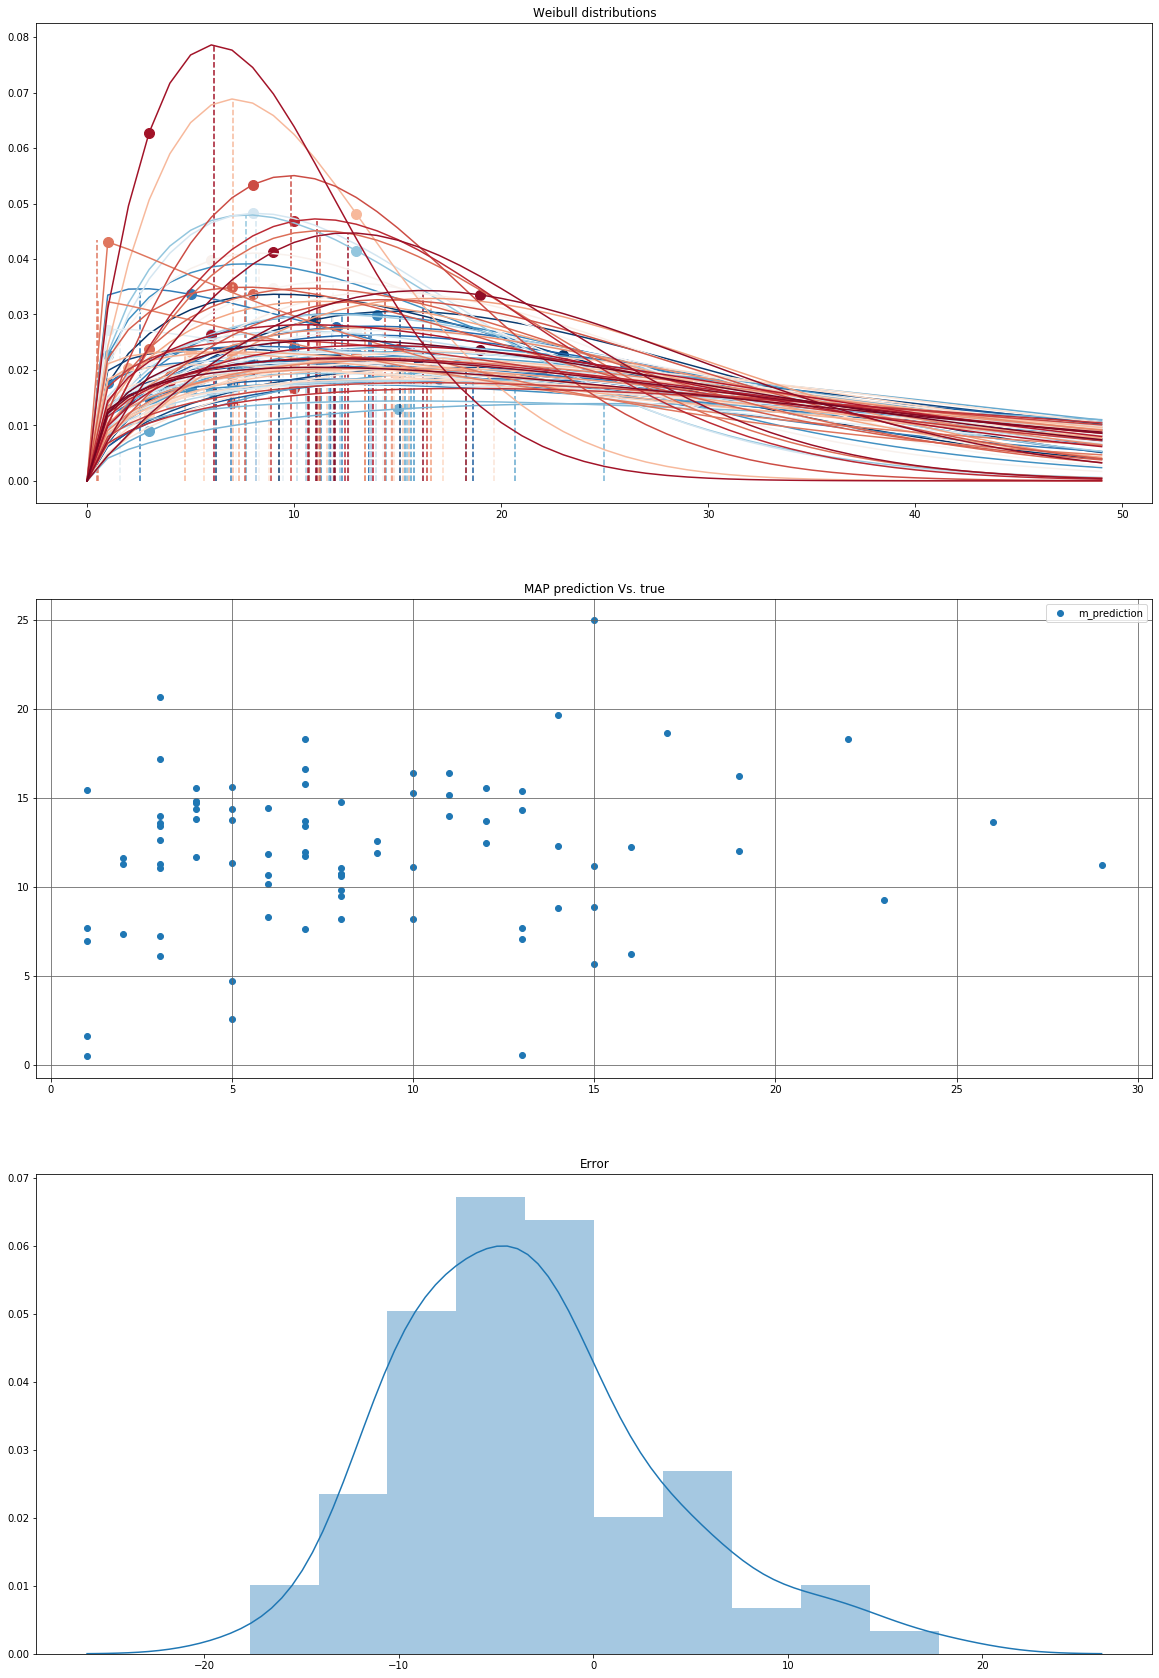

In [112]:
plot_weibull_predictions(results_df=test_results_df)